In [98]:
%run setup.py
%config IPython.matplotlib.backend = "retina"

In [99]:
def plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle):
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_edge(xobs, yobs, xedge_obs, yedge_obs, tck_obs, tp_obs, diagram=diagram, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model)
    obj_obs = distfit(hdist_obs, hist_model, bins=obj_obs.bins)
    obj_obs.fit(ifmcmc=False)

    hdist_pdv, xpdv, ypdv = distance_to_edge(xpdv, ypdv, xedge_pdv, yedge_pdv, tck_pdv, tp_pdv, diagram=diagram, distance=distance)
    obj_pdv = distfit(hdist_pdv, hist_model, bins=obj_obs.bins)
    obj_pdv.fit(ifmcmc=False)

    Ndata = xpdv.shape[0]

    # tied to model6
    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True


    if distance=="vertical":
        fy2_base = np.random.normal(size=Ndata)
        fp = ypdv*fy2_base
    else:
        # fx1 = np.array([random.gauss(0,1) for i in range(Ndata)]) * 10.0**scipy.signal.resample(np.log10(e_xobs), Ndata) * scalar
        # "horizontal"
        fx2_base = np.random.normal(size=Ndata)
        fp = xpdv*fx2_base


    def model(theta):#, obj_obs, xpdv, ypdv):

        # theta[0]: offset in distance
        # theta[1]: perturb

        # disturb with artificial scatter
        # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

        hdist = hdist_pdv + fp*theta[1]
        hdist = hdist + theta[0]
        obj = distfit(hdist, hist_model, bins=obj_obs.bins)

        # normalize the number of points in the weighted region
        if np.sum(obj.histy[weight])!=0:
            number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
        else:
            number_reduction_factor = 0.
        histy = obj.histy * number_reduction_factor
        return histy, hdist, number_reduction_factor

    # result plot
    fig = plt.figure(figsize=mnras_size())
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    obj_obs.plot_hist(ax=axes[0], histkwargs={"color":"red", "label":"Kepler", "zorder":100})
    obj_obs.plot_fit(ax=axes[0], fitkwargs={"color":"black", "linestyle":"--", "zorder":100})
    # obj_pdv.plot_hist(ax=axes[0], histkwargs={"color":"green", "label":"Galaxia initial model"})


    # plot three different combinations
    scatters = scatters
    colors = sns.light_palette("navy", n_colors=4, reverse=True)#sns.dark_palette("blue", 4)[::-1]
    for i in range(len(scatters)):
        # calculate best fitted results
        para_fit = [0, scatters[i]]
        yfit, hdist, number_reduction_factor = model(para_fit)
        Ndata = hdist.shape[0]
        idx = reduce_samples(Ndata, Ndata*number_reduction_factor)

        if distance=="vertical":
            xdata = xpdv
            ydata = ypdv + fp*para_fit[1]
        else:
            xdata = xpdv + fp*para_fit[1]
            ydata = ypdv

        xfit, yfit = xdata[idx], ydata[idx]
        hdist_fit, xfit, yfit = distance_to_edge(xfit, yfit, xedge_pdv, yedge_pdv, tck_pdv, tp_pdv, diagram=diagram, distance=distance)
        hdist_fit = hdist_fit + para_fit[0]

        obj_fit = distfit(hdist_fit, hist_model, bins=obj_obs.bins)
        obj_fit.fit(ifmcmc=False)
        str_scatter = "{:0.1f}\%".format(scatters[i]*100)
        label = "$\\sigma_{"+variable+"}="+str_scatter+"$" #"$r_{"+variable+"}=0$, 
        axes[0].step(obj_fit.histx, obj_fit.histy, **{"color":colors[i], "label":label, "linewidth":0.5})


    axes[0].grid(True)
    axes[0].set_ylim(0., obj_obs.histy.max()*1.5)
    axes[0].set_xlabel(xtitle)
    axes[0].set_ylabel("Counts")
    axes[0].legend()
    # fill weighted region
    xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
    lr = xmax_ - xmin_
    axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
    axes[0].set_xlim(xmin_-lr*1.0, xmax_+lr*1.3)

    # plt.show()
    plt.tight_layout()
    plt.savefig(overleaf_path+filename)
    # plt.close()


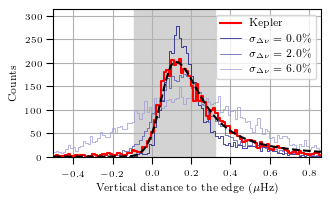

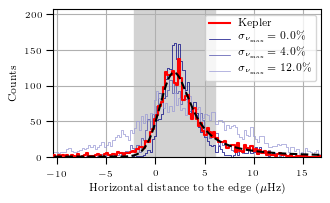

In [100]:
yu = np.load(work_path+'sample/yu/yu18.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/yu/tnu_edge_samples.npy')
tck_obs, tp_obs = np.load(work_path+"sample/yu/nike_spline_tck.npy", allow_pickle=True)
xobs, yobs = yu["numax"], yu["dnu"]
xedge_obs, yedge_obs = edge[:,0], edge[:,1]

pdv = np.load(work_path+'sample/padova/padova.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/padova/tnu_edge_samples.npy')
tck_pdv, tp_pdv = np.load(work_path+'sample/padova/nike_spline_tck.npy', allow_pickle=True)
xpdv, ypdv = pdv["numax"], pdv["dnu"]
xedge_pdv, yedge_pdv = edge[:,0], edge[:,1]

from lib.histdist import distance_to_edge, distfit, model6, reduce_samples
diagram = "tnu"
hist_model = model6()


distance = "vertical"
variable = "\Delta\\nu"
filename = "model_hist_dnu.pdf"
xtitle = "Vertical distance to the edge ($\\mu$Hz)"
scatters = [0, 0.02, 0.06]
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle)

distance = "horizontal"
variable = "\\nu_{\\rm max}"
filename = "model_hist_numax.pdf"
xtitle = "Horizontal distance to the edge ($\\mu$Hz)"
scatters = [0, 0.04, 0.12]
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle)

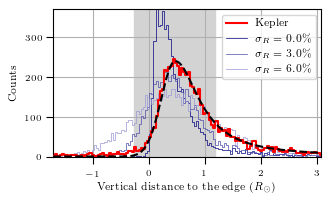

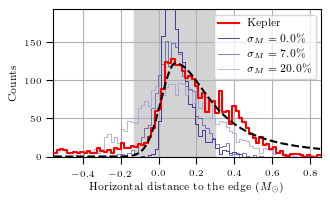

In [101]:
yu = np.load(work_path+'sample/yu/yu18.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/yu/mr_edge_samples.npy')
tck_obs, tp_obs = np.load(work_path+"sample/yu/mr_spline_tck.npy", allow_pickle=True)
xobs, yobs = yu["mass"], yu["radius"]
xedge_obs, yedge_obs = edge[:,0], edge[:,1]

pdv = np.load(work_path+'sample/padova/padova.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/padova/mr_edge_samples.npy')
tck_pdv, tp_pdv = np.load(work_path+'sample/padova/mr_spline_tck.npy', allow_pickle=True)
xpdv, ypdv = pdv["mass"], pdv["radius"]
xedge_pdv, yedge_pdv = edge[:,0], edge[:,1]

from lib.histdist import distance_to_edge, distfit, model6, reduce_samples
diagram = "mr"
hist_model = model6()


distance = "vertical"
variable = "R"
filename = "model_hist_radius.pdf"
scatters = [0, 0.03, 0.06]
xtitle = "Vertical distance to the edge ($R_{\odot}$)"
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle)

distance = "horizontal"
variable = "M"
filename = "model_hist_mass.pdf"
scatters = [0, 0.07, 0.20]
xtitle = "Horizontal distance to the edge ($M_{\odot}$)"
plot_model(distance, variable, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs,
            tck_pdv, tp_pdv, xpdv, ypdv, xedge_pdv, yedge_pdv, filename, scatters, xtitle)